# Cusp Analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
import pandas as pd
import sidetable
import utils
import StressTools as tools

## Clean up cusp data file

In [2]:
raw = pd.read_csv('cuspData/CuspDataFromKyleMohr.csv')

# Remove extra measurements beyond 2
raw = raw.groupby('Cusp_ID').head(2)

# Remove items that only have 1 angle measurement
freq = raw.stb.freq(['Cusp_ID'])
singles = freq.loc[freq['Count'] < 2]
mask = ~raw.Cusp_ID.isin(singles.Cusp_ID)
cusps = raw[mask].copy()

### Convert latitudes and longitudes

In [3]:
cusps['lon'] = (360 - cusps['Long_dd']) % 360
cusps['lat'] = 90 - cusps['Lat_dd']

## Split data into left and right groups

In [4]:
left_cusps = cusps.iloc[::2]
right_cusps = cusps.iloc[1::2]

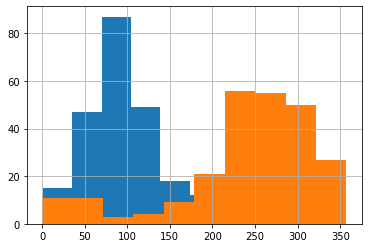

In [5]:
left_cusps.CompassA.hist()
right_cusps.CompassA.hist()

## Get stress field for cusps

In [6]:
interior = interior = utils.import_interior('interior1')

left_coords = left_cusps[['lat', 'lon']]
right_coords = right_cusps[['lat', 'lon']]

left_stress = tools.get_simon_stress_field(interior, left_coords, 0, 0.01, 0, 0)
right_stress = tools.get_simon_stress_field(interior, right_coords, 0, 0.01, 0, 0)

## Match Angles to stresses

In [16]:
def match_angles(points, stresses, name, show_plots=True):
    results = []
    
    for point in points.itertuples():
        stress_data = stresses.loc[(stresses.lon == point.lon) & (stresses.lat == point.lat)]
        
        sorted_stress = stress_data.copy().sort_values('heading')
        angle = point.CompassA if point.CompassA > 180 else (180 + point.CompassA) % 360

        spline = InterpolatedUnivariateSpline(sorted_stress.heading, sorted_stress.stress)
        slopes = spline.derivative()
        
        matched_stress = spline(angle)
        slope = slopes(angle)
        is_increasing = slope > 0
        max_stress = stress_data.stress.max()
        min_stress = stress_data.stress.min()

        if show_plots:
            plt.figure()
            plt.title(f'{name} - lat: {point.lat}, lon: {point.lon}')
            plt.vlines(angle, ymin=min_stress, ymax=max_stress, colors=['red'], linestyles='dashed')
            plt.hlines(matched_stress, xmin=175, xmax=360, colors=['red'], linestyles='dashed')

            spx = np.linspace(180, 360, 360)
            plt.plot(spx, spline(spx))
            plt.show()

        
        results.append(dict(lat=point.lat,
                            lon=point.lon,
                            Id=point.Id,
                            cycloid_number=point.Cycloid_Nu,
                            cusp_id=point.Cusp_ID,
                            orientation_original=point.CompassA,
                            orientation_translated=angle,
                            stress=matched_stress, 
                            max_stress=max_stress, 
                            slope=slope,
                            is_increasing=is_increasing))
        
    return pd.DataFrame(results)

In [21]:
left_points = left_cusps #.loc[left_cusps.Cycloid_Nu == 13]
right_points = right_cusps #.loc[right_cusps.Cycloid_Nu == 13]


left_matched = match_angles(left_points, left_stress, 'Left Side', show_plots=False)
right_matched = match_angles(right_points, right_stress, 'Right Side', show_plots=False)
left_matched['cusp_direction'] = 'left'
right_matched['cusp_direction'] = 'right'

## Output Unified Dataset

In [26]:
all_matches = pd.concat([left_matched, right_matched])
all_matches.to_csv('./output/leftRight/interpolatedStress.csv.gz', compression='gzip', index=False)